<a href="https://colab.research.google.com/github/fediAou/Sementic-Segmentation-/blob/main/Sementic_Segmentation_Vaihingen_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive to Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import dependencies


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import concatenate, UpSampling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.metrics import OneHotMeanIoU, OneHotIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import numpy as np

from os.path import join,basename,splitext
import os
from glob import glob

from natsort import natsorted
import tifffile
from PIL import Image

import random

## Visualization

In [ ]:
# Walk through the data file
DATA_DIR = '/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen'
for dirpath, dirnames, filenames in os.walk(DATA_DIR):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen'.
There are 0 directories and 33 images in '/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/dsm'.
There are 0 directories and 33 images in '/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/top'.
There are 0 directories and 33 images in '/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/gts'.


In [ ]:
# Get all image paths in a list (dsm)
path_list_dsm = []
DSM_DIR = '/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/dsm'

for dirpath, dirnames, filenames in os.walk(DSM_DIR):
  path_list_dsm.append(filenames)

In [ ]:
# Get all image paths in a list (gts)
path_list_gts = []
GTS_DIR = '/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/gts'

for dirpath, dirnames, filenames in os.walk(GTS_DIR):
  path_list_gts.append(filenames)

In [ ]:
# Get all image paths in a list (top)
path_list_top = []
TOP_DIR = '/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/top'

for dirpath, dirnames, filenames in os.walk(TOP_DIR):
  path_list_top.append(filenames)

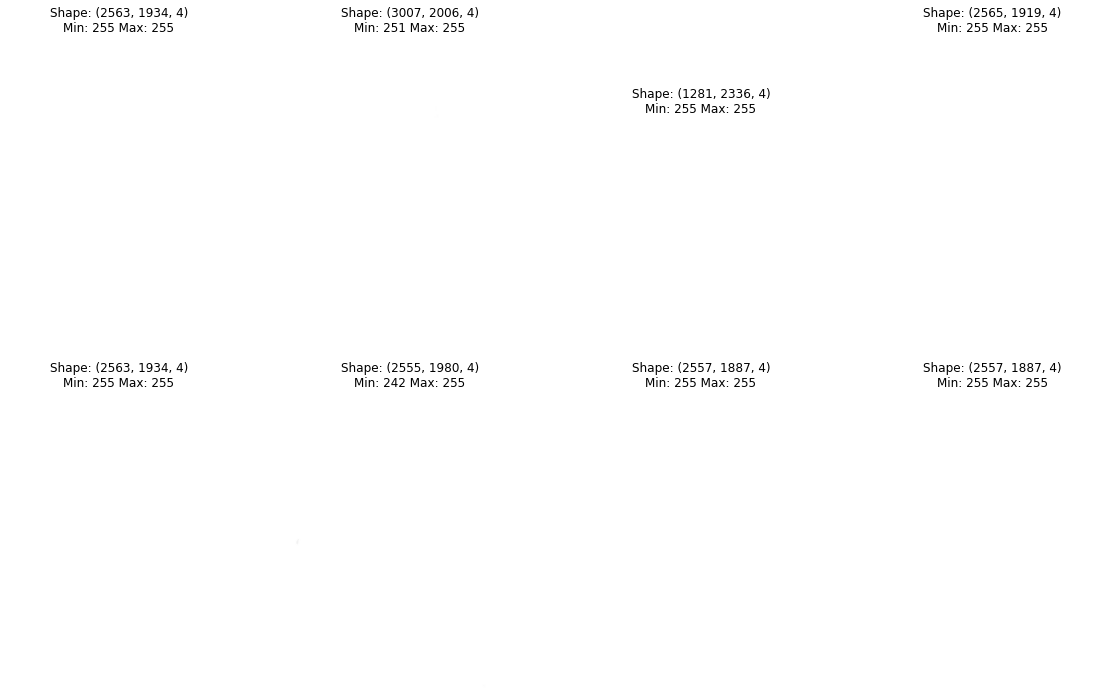

In [ ]:
# View some random images (dsm)
plt.figure(figsize=(20,25))

for i in range(8):
  plt.subplot(4,4,i+1)

  random_path = DSM_DIR + '/' + random.choice(path_list_dsm[0])
  random_image = mpimg.imread(random_path)
  plt.imshow(random_image)

  plt.title(f"Shape: {random_image.shape}\nMin: {random_image.min()} Max: {random_image.max()}")

  plt.axis(False)

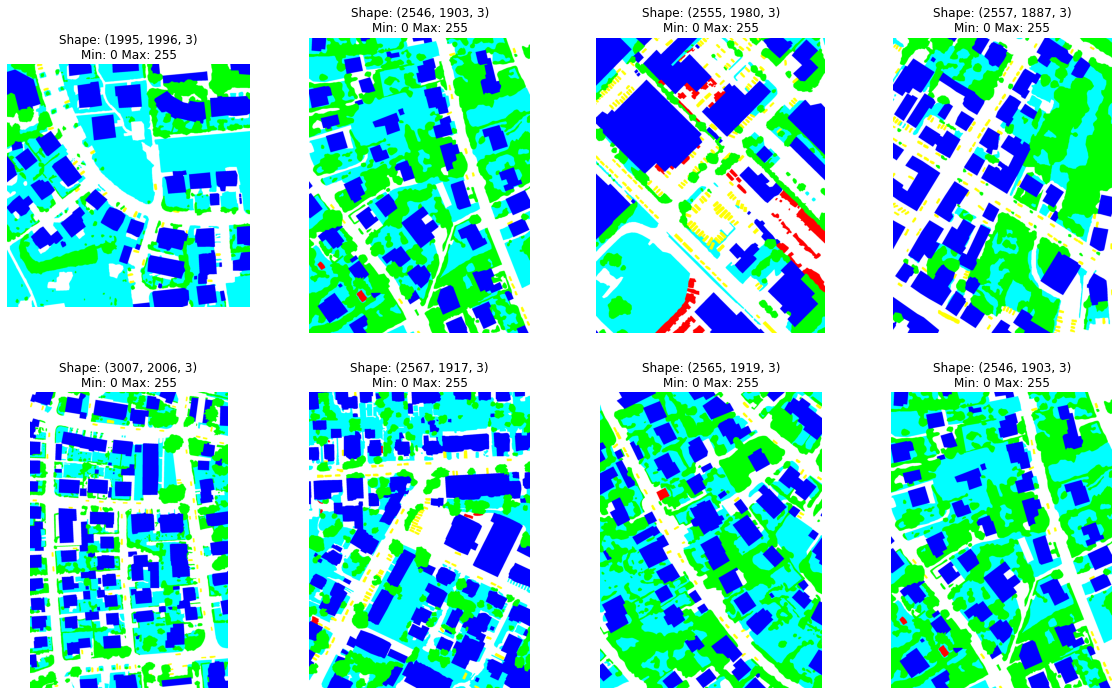

In [ ]:
# View some random images (gts)
plt.figure(figsize=(20,25))

for i in range(8):
  plt.subplot(4,4,i+1)

  random_path = GTS_DIR + '/' + random.choice(path_list_gts[0])
  random_image = mpimg.imread(random_path)
  plt.imshow(random_image)

  plt.title(f"Shape: {random_image.shape}\nMin: {random_image.min()} Max: {random_image.max()}")

  plt.axis(False)

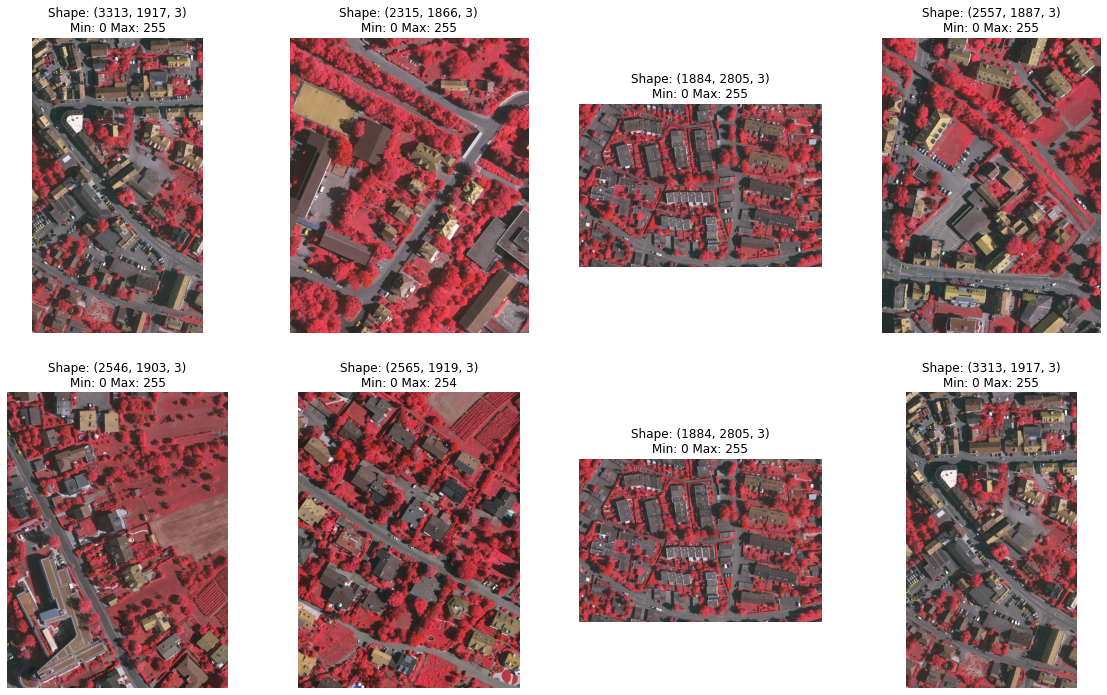

In [ ]:
# View some random images (top)
plt.figure(figsize=(20,25))

for i in range(8):
  plt.subplot(4,4,i+1)

  random_path = TOP_DIR + '/' + random.choice(path_list_top[0])
  random_image = mpimg.imread(random_path)
  plt.imshow(random_image)

  plt.title(f"Shape: {random_image.shape}\nMin: {random_image.min()} Max: {random_image.max()}")

  plt.axis(False)

## Reading all images from the _top_, _dsm_ and _gts_ folders

In [ ]:
path_top = join(DATA_DIR,"top")
path_dsm = join(DATA_DIR,"dsm")
path_gts = join(DATA_DIR,"gts")


list_top = glob(join(path_top,"*.tif"))
list_top = natsorted(list_top, key=lambda y: y.lower())

list_dsm = glob(join(path_dsm,"*.tif"))
list_dsm = natsorted(list_dsm, key=lambda y: y.lower())

list_gts = glob(join(path_gts,"*.tif"))
list_gts = natsorted(list_gts, key=lambda y: y.lower())

## Train, Validation and Test dataset


In [ ]:
# Images IDs for train and test
train_ids = [1,3,5,7,11,13,15,17,21,23,26,28,30,32,34,37]
test_ids = [2,4,6,8,10,12,14,16,20,22,24,27,29,31,33,35,38]

list_top_train, list_top_val, list_top_test = ([] for i in range(3))
list_dsm_train, list_dsm_val, list_dsm_test = ([] for i in range(3))
list_gts_train, list_gts_val, list_gts_test = ([] for i in range(3))

In [ ]:
for top,dsm,gts in zip(list_top,list_dsm,list_gts):
  # Get the aread ID from the filename
  area_id = int(splitext(basename(top))[0].split("area")[-1])
  # Train set
  if area_id in train_ids:
    list_top_train.append(top)
    list_dsm_train.append(dsm)
    list_gts_train.append(gts)
  # Test set
  elif area_id in test_ids:
    list_top_test.append(top)
    list_dsm_test.append(dsm)
    list_gts_test.append(gts)

# shuffle train lists
temp = list(zip(list_top_train,list_dsm_train,list_gts_train))
random.seed(10)
random.shuffle(temp)
list_top_train,list_dsm_train,list_gts_train = zip(*temp)

# take 25% as validation set
p_val = 0.25
n_val = int(p_val*len(list_top_train))

list_top_val = list_top_train[:n_val]
list_top_train = list_top_train[n_val:]

list_dsm_val = list_dsm_train[:n_val]
list_dsm_train = list_dsm_train[n_val:]

list_gts_val = list_gts_train[:n_val]
list_gts_train = list_gts_train[n_val:]

## Get information about the dataset

In [ ]:
def print_info(list_top,list_dsm,list_gts):
  for top,dsm,gts in zip(list_top,list_dsm,list_gts):
    gt_temp = tifffile.imread(gts)
    n_classes = len(np.unique(gt_temp.reshape(gt_temp.shape[0]*gt_temp.shape[1],-1),axis=0))
    print("TOP:{} , DSM:{} , GT:{} , N:{}".format(basename(top),
                                  basename(dsm),
                                  basename(gts),
                                  n_classes))

In [ ]:
# Train
print("Train:")
print_info(list_top_train,list_dsm_train,list_gts_train)

# Validation
print("\nValidation:")
print_info(list_top_val,list_dsm_val,list_gts_val)

# Test
print("\nTest:")
print_info(list_top_test,list_dsm_test,list_gts_test)

Train:
TOP:top_mosaic_09cm_area28.tif , DSM:dsm_09cm_matching_area28.tif , GT:top_mosaic_09cm_area28.tif , N:6
TOP:top_mosaic_09cm_area37.tif , DSM:dsm_09cm_matching_area37.tif , GT:top_mosaic_09cm_area37.tif , N:5
TOP:top_mosaic_09cm_area13.tif , DSM:dsm_09cm_matching_area13.tif , GT:top_mosaic_09cm_area13.tif , N:5
TOP:top_mosaic_09cm_area11.tif , DSM:dsm_09cm_matching_area11.tif , GT:top_mosaic_09cm_area11.tif , N:5
TOP:top_mosaic_09cm_area30.tif , DSM:dsm_09cm_matching_area30.tif , GT:top_mosaic_09cm_area30.tif , N:5
TOP:top_mosaic_09cm_area32.tif , DSM:dsm_09cm_matching_area32.tif , GT:top_mosaic_09cm_area32.tif , N:6
TOP:top_mosaic_09cm_area7.tif , DSM:dsm_09cm_matching_area7.tif , GT:top_mosaic_09cm_area7.tif , N:5
TOP:top_mosaic_09cm_area1.tif , DSM:dsm_09cm_matching_area1.tif , GT:top_mosaic_09cm_area1.tif , N:6
TOP:top_mosaic_09cm_area23.tif , DSM:dsm_09cm_matching_area23.tif , GT:top_mosaic_09cm_area23.tif , N:6
TOP:top_mosaic_09cm_area17.tif , DSM:dsm_09cm_matching_area17.t

## Create the classes

In [ ]:
color2index = {(255,255,255) : 0,
               (0  ,0  ,255) : 1,
               (0  ,255,255) : 2,
               (0  ,255,0  ) : 3,
               (255,255,0  ) : 4,
               (255,0  ,0  ) : 5
               }
n_classes = len(color2index)

## Class DataGenerator

In [ ]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self,
               batch_size,
               patch_size,
               step_size,
               list_top,
               list_gts,
               n_classes,
               colormap_gt=None,
               augmentation=None,
               preprocessing=None,
               shuffle=True):
    self.batch_size = batch_size
    self.patch_size = patch_size
    self.step_size = step_size
    self.list_top = list_top
    self.list_gts = list_gts
    self.n_classes = n_classes
    self.colormap_gt = colormap_gt
    self.augmentation = augmentation
    self.preprocessing = preprocessing
    self.shuffle= shuffle
    self.path_coords = self.__get_path_coords()
    self.n_patchs = len(self.path_coords)

  def __get_path_coords(self):
    path_coords = []
    for path_image, path_label in zip(self.list_top,self.list_gts):
      width, height = Image.open(path_label).size
      for y in range(0, height, self.step_size):
        for x in range(0, width, self.step_size):
          if (x + self.patch_size) > width:
            x = width - self.patch_size
          if (y + self.patch_size) > height:
            y = height - self.patch_size

          path_coords.append((path_image, path_label, (x,y)))
    return path_coords

  def on_epoch_end(self):
    if self.shuffle:
      random.shuffle(self.path_coords)

  def __len__(self):
    return np.ceil(self.n_patchs/self.batch_size).astype("int")

  def __get_patch_image(self, path_image, x, y):
    # Reading the RGB image
    data_image = Image.open(path_image)
    data_image = data_image.crop((x, y,
                                  x + self.patch_size, y + self.patch_size))
    data_image = np.asarray(data_image).astype("float32")

    return data_image/255.0

  def __get_patch_mask(self, path, x, y):
    # Reading the mask
    data_mask = Image.open(path)
    data_mask = data_mask.crop((x, y,
                                x + self.patch_size, y + self.patch_size))
    data_mask = np.asarray(data_mask)
    # Convert RGB image [H x W x 3] to label image [H x W x 1]
    data_mask_idx = np.zeros((data_mask.shape[0],
                              data_mask.shape[1]), dtype=np.uint8)
    for key in self.colormap_gt:
      class_id = self.colormap_gt[key]
      key = np.array(key)
      # Assign an index to each color based on the colormap
      # (255,255,255) : 0
      # (0  ,0  ,255) : 1,...
      data_mask_idx[(data_mask[:,:,0] == key[0]) &
                    (data_mask[:,:,1] == key[1]) &
                    (data_mask[:,:,2] == key[2])] = class_id
    return data_mask_idx

  def __getitem__(self, idx):
    i = idx * self.batch_size

    current_batch_size = self.batch_size
    if (idx+1) == self.__len__():
      current_batch_size = len(self.path_coords[i:])

    # Batch of coordinates
    batch_path_coords = self.path_coords[i : i + current_batch_size]

    x = np.zeros((current_batch_size,
                  self.patch_size,
                  self.patch_size,
                  3),
                  dtype=np.float32)

    y = np.zeros((current_batch_size,
                  self.patch_size,
                  self.patch_size,
                  self.n_classes),
                  dtype=np.float32)

    for j, (path_image, path_label, (x_pos, y_pos)) in enumerate(batch_path_coords):
      # Get an individual image and its corresponding label
      x_sample = self.__get_patch_image(path_image, x_pos, y_pos)
      y_sample = self.__get_patch_mask(path_label, x_pos, y_pos)

      # If there are augmentation transformations, apply them
      if self.augmentation is not None:
        augmented = self.augmentation()(image=x_sample, mask=y_sample)
        x_sample = augmented["image"]
        y_sample = augmented["mask"]
      # If there is a preprocessing function, apply it
      if self.preprocessing is not None:
        preprocessed = self.preprocessing(image=x_sample, mask=y_sample)
        x_sample = preprocessed['image']
        y_sample = preprocessed['mask']
      # Convert labels to one hot encoding
      y_sample = to_categorical(y_sample, self.n_classes)

      x[j,...] = x_sample
      y[j,...] = y_sample
    return x, y

## Apply datagenerator to the train and val dataset

In [ ]:
batch_size = 8
patch_size = 256
step_size = 256

data_gen_train = DataGenerator(batch_size=batch_size,
                               patch_size=patch_size,
                               step_size=step_size,
                               list_top=list_top_train,
                               list_gts=list_gts_train,
                               n_classes=n_classes,
                               colormap_gt=color2index
                               )

data_gen_val = DataGenerator(batch_size=batch_size,
                             patch_size=patch_size,
                             step_size=step_size,
                             list_top=list_top_val,
                             list_gts=list_gts_val,
                             n_classes=n_classes,
                             colormap_gt=color2index
                             )

In [ ]:
def conv_block(x, n_filters, times=2):
  for i in range(times):
    x = Conv2D(filters=n_filters,
              kernel_size=3,
              strides=1,
              padding="same",
              activation="relu",
              kernel_initializer="he_normal")(x)
  return x

def downsampling(x, n_filters, times=2):
  feat = conv_block(x, n_filters, times=times)
  pool = MaxPooling2D(pool_size=2)(feat)
  pool = Dropout(rate=0.3)(pool)
  return feat,pool

def upsampling(input, filters, layer_concat=None):
  x = UpSampling2D(size=(2, 2),
                interpolation="nearest")(input)
  if layer_concat is not None:
    x = concatenate([x, layer_concat])
  x = Dropout(rate=0.3)(x)
  x = conv_block(x, filters, times=2)
  return x

In [ ]:
def get_unet(img_size, n_classes):
  # Input
  input = Input(shape=(img_size,img_size,3))
  # Downsampling
  f1,p1 = downsampling(input, 64, times=2)
  f2,p2 = downsampling(p1, 128, times=2)
  f3,p3 = downsampling(p2, 256, times=2)
  # Bottleneck
  blottleneck = conv_block(p3, 512, times=2)
  #Upsampling
  u7 = upsampling(blottleneck, 256, layer_concat=f3)
  u8 = upsampling(u7, 128, layer_concat=f2)
  u9 = upsampling(u8, 64, layer_concat=f1)
  # Output
  output = Conv2D(filters=n_classes,
                  kernel_size=1,
                  padding="same",
                  activation="softmax")(u9)
  model = Model(inputs=input, outputs=output, name="UNet")

  return model

In [ ]:
model_unet = get_unet(img_size=patch_size,
                    n_classes=n_classes)

In [ ]:
model_unet.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                              

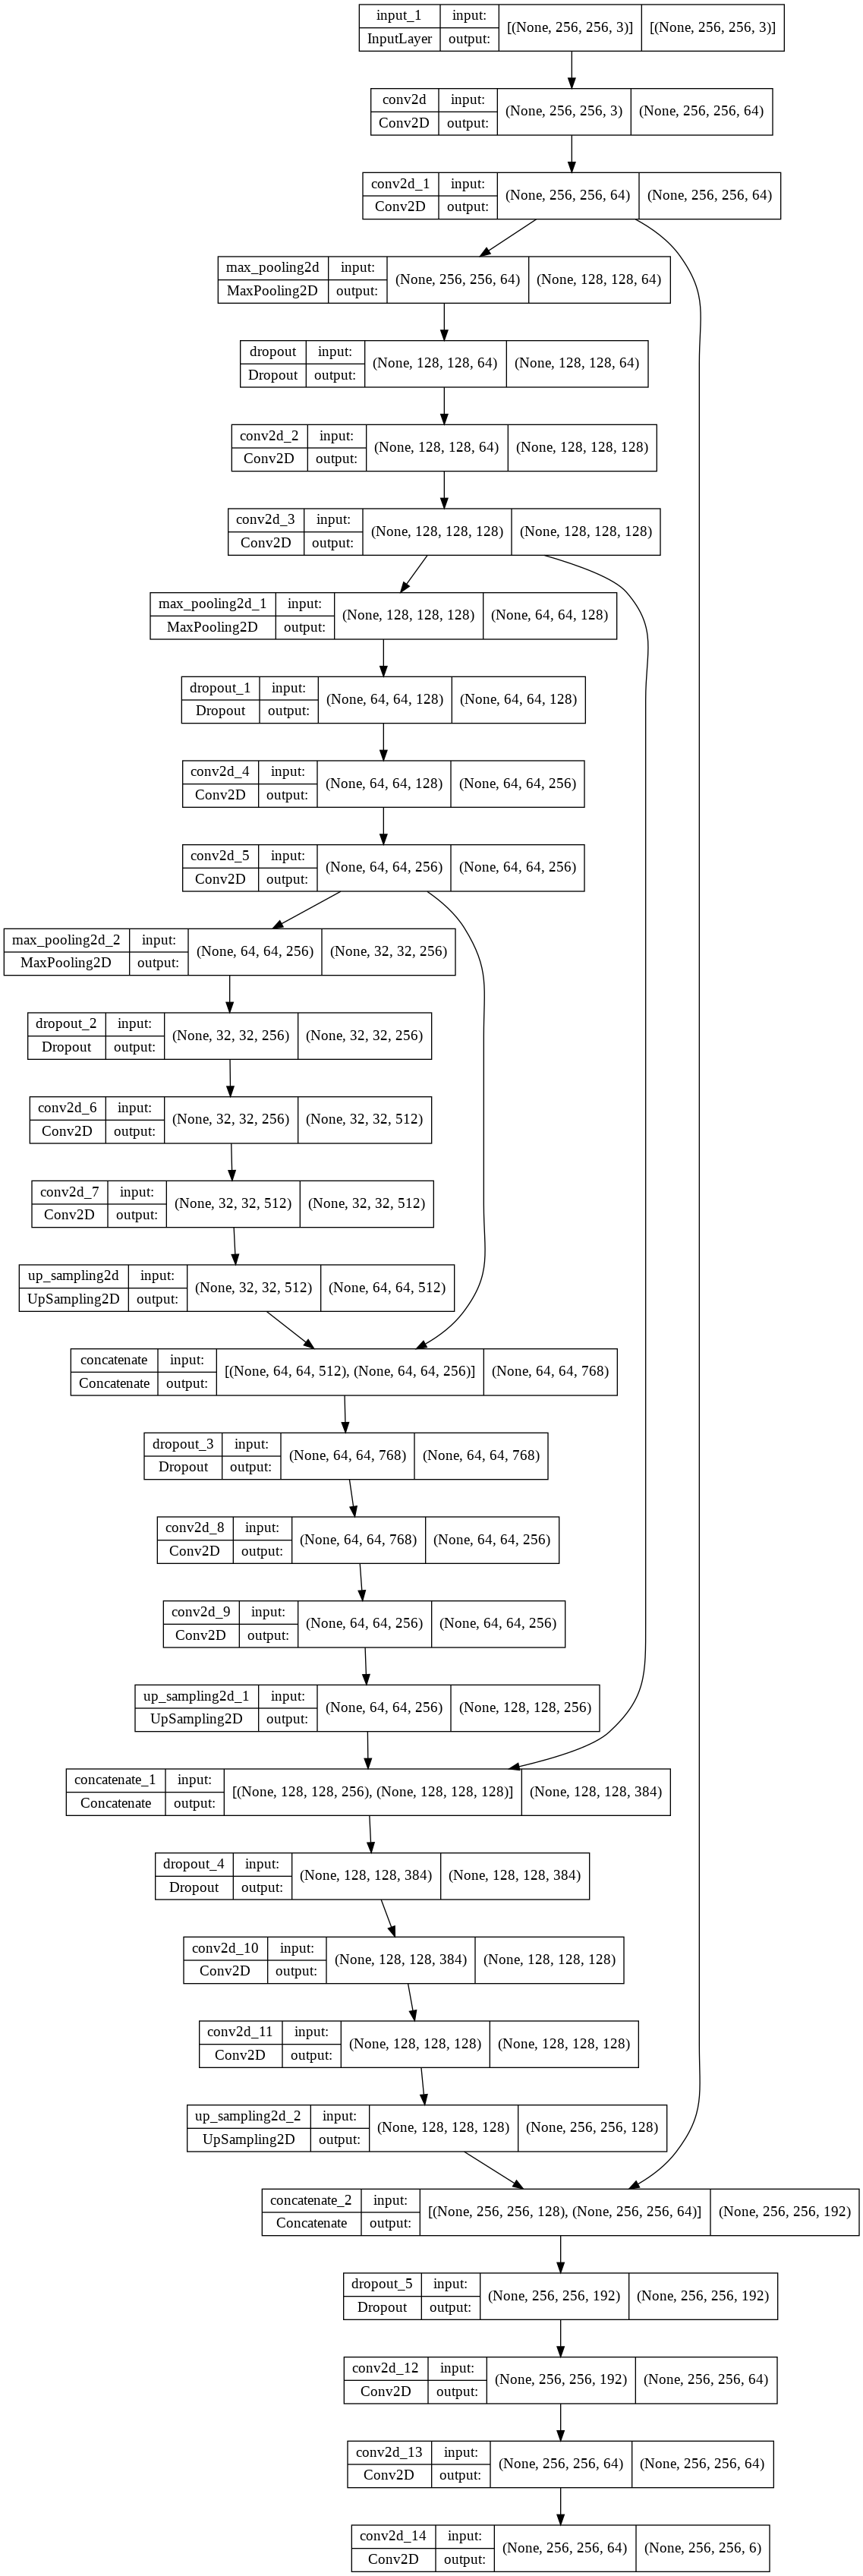

In [ ]:
plot_model(model_unet, to_file="model_unet_2.png", show_shapes=True)

In [ ]:
model_unet.compile(optimizer=Adam(),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", OneHotMeanIoU(num_classes=n_classes, name="iou")])

In [ ]:
def get_ckpt(ckpt_name):
    return ModelCheckpoint(ckpt_name,
                           mode="max",
                           save_best_only=True,
                           monitor="val_iou",
                           verbose=1)

In [ ]:
autosave_unet = get_ckpt("segmentation_unet.h5")

In [ ]:
early_stopping = EarlyStopping(patience=30, verbose=1, mode = 'auto')

In [ ]:
# Tensorboard
logdir = os.path.join("logs", "UNet_with_Unpooling_layer")
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

In [ ]:
history_unet = model_unet.fit(data_gen_train,
                              epochs=15,
                              steps_per_epoch=len(data_gen_train)//batch_size,
                              validation_data=data_gen_val,
                              validation_steps=len(data_gen_val)//batch_size,
                              callbacks=[autosave_unet, early_stopping, tensorboard_callback],
                              workers=4,
                              use_multiprocessing=True,
                              max_queue_size=20
                              )

Epoch 1/15
16/16 [==============================] - ETA: 0s - loss: 2.3061 - accuracy: 0.2573 - iou: 0.0964 
Epoch 1: val_iou improved from -inf to 0.11301, saving model to segmentation_unet.h5
16/16 [==============================] - 871s 54s/step - loss: 2.3061 - accuracy: 0.2573 - iou: 0.0964 - val_loss: 1.4137 - val_accuracy: 0.3917 - val_iou: 0.1130
Epoch 2/15
16/16 [==============================] - ETA: 0s - loss: 1.2204 - accuracy: 0.4631 - iou: 0.1702 
Epoch 2: val_iou improved from 0.11301 to 0.28995, saving model to segmentation_unet.h5
16/16 [==============================] - 874s 54s/step - loss: 1.2204 - accuracy: 0.4631 - iou: 0.1702 - val_loss: 1.0835 - val_accuracy: 0.6814 - val_iou: 0.2899
Epoch 3/15
16/16 [==============================] - ETA: 0s - loss: 1.0359 - accuracy: 0.5498 - iou: 0.2374 
Epoch 3: val_iou did not improve from 0.28995
16/16 [==============================] - 851s 52s/step - loss: 1.0359 - accuracy: 0.5498 - iou: 0.2374 - val_loss: 1.0635 - val_

In [ ]:
data_gen_test = DataGenerator(batch_size=batch_size,
                              patch_size=patch_size,
                              step_size=step_size,
                              list_top=list_top_test,
                              list_gts=list_gts_test,
                              n_classes=n_classes,
                              colormap_gt=color2index
                              )

model_unet.evaluate(data_gen_test)

190/190 [==============================] - 2517s 13s/step - loss: 0.8645 - accuracy: 0.6497 - iou: 0.3205


[0.8645053505897522, 0.6496885418891907, 0.32049527764320374]

In [ ]:
# Tensorboard Dev
!tensorboard dev upload --logdir logs --name "U-Net Unpooling layer" --one_shot